In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
with open('benchmarking_results.json', 'r') as f:
    benchmark_data = json.load(f)
    
benchmark_data

{'llama-wth-not_quantized': {'module': 'pipelines.llama_pipeline',
  'function': 'run_llama_pipeline',
  'args': [],
  'kwargs': {'model_path': 'llama-wth/unsloth.BF16.gguf',
   'prompt_type': 'wth'},
  'dataset_name': 'zpp-murmuras/llama-ds-wth-rev3',
  'splits': {'penny': 'penny_train+penny_test',
   'edeka': 'edeka_train+edeka_test',
   'dm': 'dm_test',
   'lidl': 'lidl_test',
   'rewe': 'rewe_test',
   'rossmann': 'rossmann_test'},
  'threshold': 0.8,
  'expected': {'penny': 67,
   'edeka': 396,
   'dm': 2368,
   'lidl': 1508,
   'rewe': 2785,
   'rossmann': 473},
  'generated': {'penny': 57,
   'edeka': 862,
   'dm': 1630,
   'lidl': 1893,
   'rewe': 3076,
   'rossmann': 461},
  'matched': {'penny': 29,
   'edeka': 53,
   'dm': 1033,
   'lidl': 1355,
   'rewe': 2608,
   'rossmann': 431},
  'generation_time': {'penny': 34.000014799,
   'edeka': 486.55936486800005,
   'dm': 1032.6020598220002,
   'lidl': 1174.05673314,
   'rewe': 2717.667608568,
   'rossmann': 345.18956168100067}},


In [3]:
with open('quantization_comparison/quantization_comparison_results.json', 'r') as f:
    quant_data = json.load(f)
    
quant_data

{'not_quantized': {'prompt_eval_rate': 3.11,
  'generation_rate': 2.0,
  'file_size': 2479591168},
 'q8_0': {'prompt_eval_rate': 12.91,
  'generation_rate': 8.53,
  'file_size': 1321078528},
 'q4_k_m': {'prompt_eval_rate': 27.79,
  'generation_rate': 12.74,
  'file_size': 807689984},
 'q4_0': {'prompt_eval_rate': 40.43,
  'generation_rate': 11.16,
  'file_size': 770924288}}

In [4]:
train_apps = ['dm', 'lidl', 'rewe', 'rossmann']
data_types = ['expected', 'matched', 'generated']
benchmark_data['llama-appwise-family'] = {}
benchmark_data['bert-appwise-family'] = {}
for data_type in data_types:
    benchmark_data['llama-appwise-family'][data_type] = {}
    benchmark_data['bert-appwise-family'][data_type] = {}
    for app in train_apps:
        benchmark_data['llama-appwise-family'][data_type][app] = benchmark_data['llama-wth-appwise-' + app][data_type][app]
        benchmark_data['bert-appwise-family'][data_type][app] = benchmark_data['bert-top_score-appwise-' + app][data_type][app]

for experiment in benchmark_data.values():
    experiment['recall'] = {}
    experiment['precision'] = {}
    for dataset in experiment['expected'].keys():
        m = experiment['matched'][dataset]
        g = experiment['generated'][dataset]
        e = experiment['expected'][dataset]
        experiment['recall'][dataset] = m / e if e > 0 else 0
        experiment['precision'][dataset] = m / g if g > 0 else 0

benchmark_data

{'llama-wth-not_quantized': {'module': 'pipelines.llama_pipeline',
  'function': 'run_llama_pipeline',
  'args': [],
  'kwargs': {'model_path': 'llama-wth/unsloth.BF16.gguf',
   'prompt_type': 'wth'},
  'dataset_name': 'zpp-murmuras/llama-ds-wth-rev3',
  'splits': {'penny': 'penny_train+penny_test',
   'edeka': 'edeka_train+edeka_test',
   'dm': 'dm_test',
   'lidl': 'lidl_test',
   'rewe': 'rewe_test',
   'rossmann': 'rossmann_test'},
  'threshold': 0.8,
  'expected': {'penny': 67,
   'edeka': 396,
   'dm': 2368,
   'lidl': 1508,
   'rewe': 2785,
   'rossmann': 473},
  'generated': {'penny': 57,
   'edeka': 862,
   'dm': 1630,
   'lidl': 1893,
   'rewe': 3076,
   'rossmann': 461},
  'matched': {'penny': 29,
   'edeka': 53,
   'dm': 1033,
   'lidl': 1355,
   'rewe': 2608,
   'rossmann': 431},
  'generation_time': {'penny': 34.000014799,
   'edeka': 486.55936486800005,
   'dm': 1032.6020598220002,
   'lidl': 1174.05673314,
   'rewe': 2717.667608568,
   'rossmann': 345.18956168100067},
 

# Model comparisons

In [5]:
def model_comparison_barplot(model_score_dicts, model_names, ylabel, filename):
    n = len(model_score_dicts)

    if n == 0:
        return
    
    benchmarks = list(model_score_dicts[0].keys())
    
    valss = []
    for score_dict in model_score_dicts:
        valss.append([score_dict[b] for b in benchmarks])

    x = np.arange(len(benchmarks))
    width = 0.8

    fig, ax = plt.subplots()
    barss = []
    for i, (vals, name) in enumerate(zip(valss, model_names, strict=True)):
        offset = (i - n / 2 + 0.5) * (width / n)
        barss.append(ax.bar(x + offset, vals, width / n, label=name))

    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_title(' vs '.join(model_names))
    ax.set_xticklabels(benchmarks)
    ax.set_ylim(0, 1.1)
    ax.legend()

    for bars in barss:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        rotation=45)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

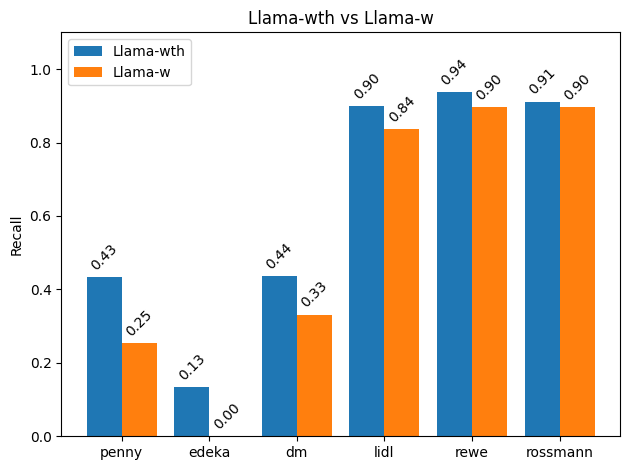

In [6]:
model_comparison_barplot(
    [
        benchmark_data['llama-wth-not_quantized']['recall'],
        benchmark_data['llama-w-not_quantized']['recall']
    ],
    [
        'Llama-wth',
        'Llama-w'
    ],
    'Recall',
    'llama_wth_vs_w_recall'
)

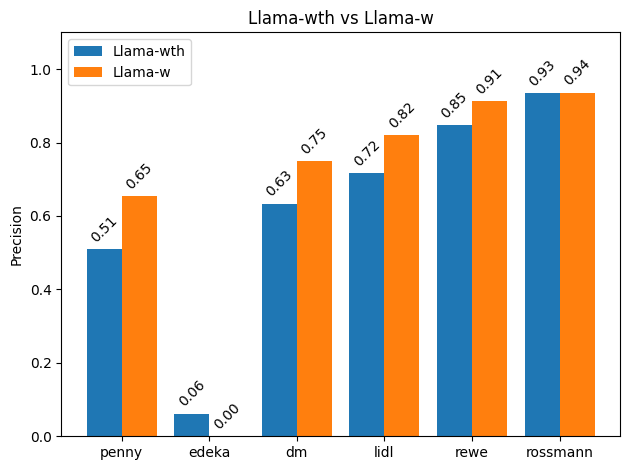

In [7]:
model_comparison_barplot(
    [
        benchmark_data['llama-wth-not_quantized']['precision'],
        benchmark_data['llama-w-not_quantized']['precision']
    ],
    [
        'Llama-wth',
        'Llama-w'
    ],
    'Precision',
    'llama_wth_vs_w_precision'
)

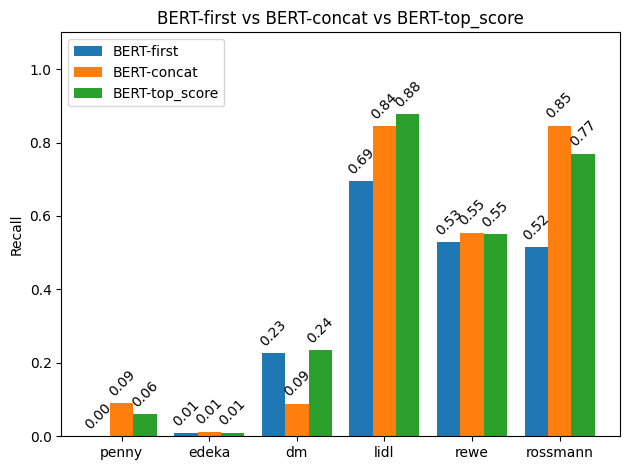

In [26]:
model_comparison_barplot(
    [
        benchmark_data['bert-no-curr-first']['recall'],
        benchmark_data['bert-no-curr-concat']['recall'],
        benchmark_data['bert-no-curr-top_score']['recall']
    ],
    [
        'BERT-first',
        'BERT-concat',
        'BERT-top_score'
    ],
    'Recall',
    'berts_recall'
)

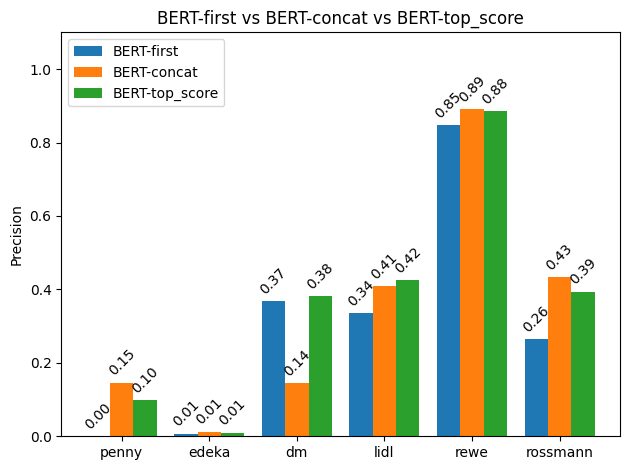

In [27]:
model_comparison_barplot(
    [
        benchmark_data['bert-no-curr-first']['precision'],
        benchmark_data['bert-no-curr-concat']['precision'],
        benchmark_data['bert-no-curr-top_score']['precision']
    ],
    [
        'BERT-first',
        'BERT-concat',
        'BERT-top_score'
    ],
    'Precision',
    'berts_precision'
)

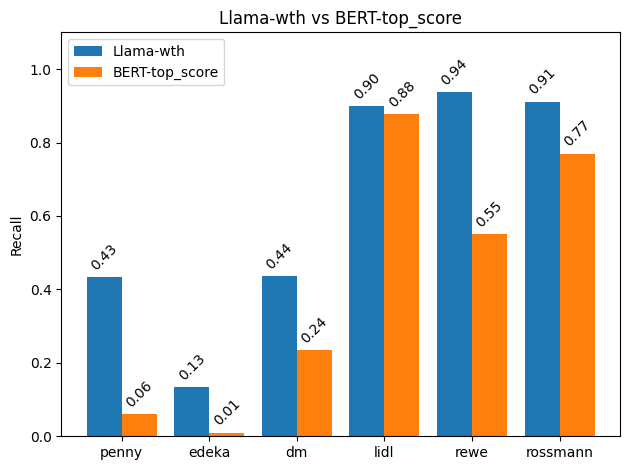

In [10]:
model_comparison_barplot(
    [benchmark_data['llama-wth-not_quantized']['recall'],
    benchmark_data['bert-no-curr-top_score']['recall']],
    ['Llama-wth',
    'BERT-top_score'],
    'Recall',
    'llama_vs_bert_recall'
)

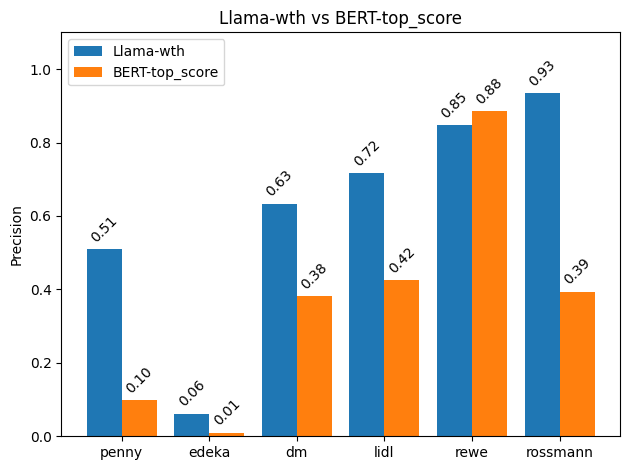

In [11]:
model_comparison_barplot(
    [benchmark_data['llama-wth-not_quantized']['precision'],
    benchmark_data['bert-no-curr-top_score']['precision']],
    ['Llama-wth',
    'BERT-top_score'],
    'Precision',
    'llama_vs_bert_precision'
)

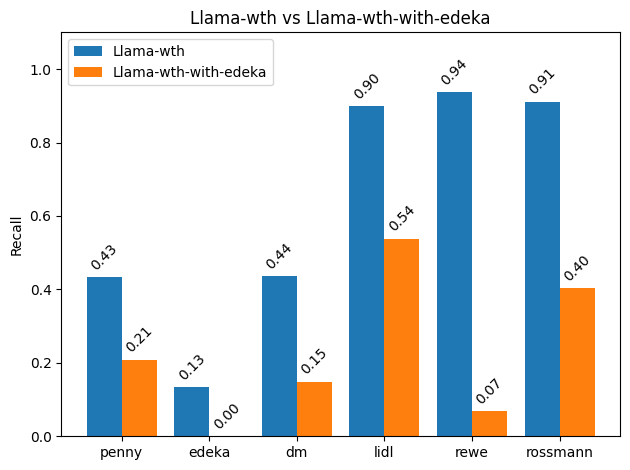

In [12]:
model_comparison_barplot(
    [benchmark_data['llama-wth-not_quantized']['recall'],
    benchmark_data['llama-wth-with-edeka']['recall']],
    ['Llama-wth',
    'Llama-wth-with-edeka'],
    'Recall',
    'llama_vs_llama_with_edeka_recall'
)

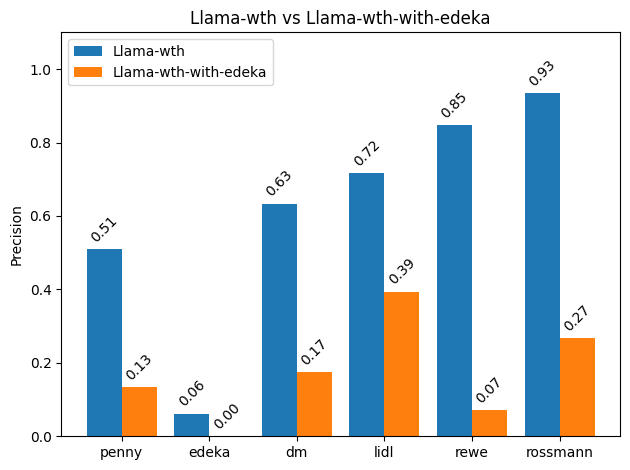

In [13]:
model_comparison_barplot(
    [benchmark_data['llama-wth-not_quantized']['precision'],
    benchmark_data['llama-wth-with-edeka']['precision']],
    ['Llama-wth',
    'Llama-wth-with-edeka'],
    'Precision',
    'llama_vs_llama_with_edeka_precision'
)

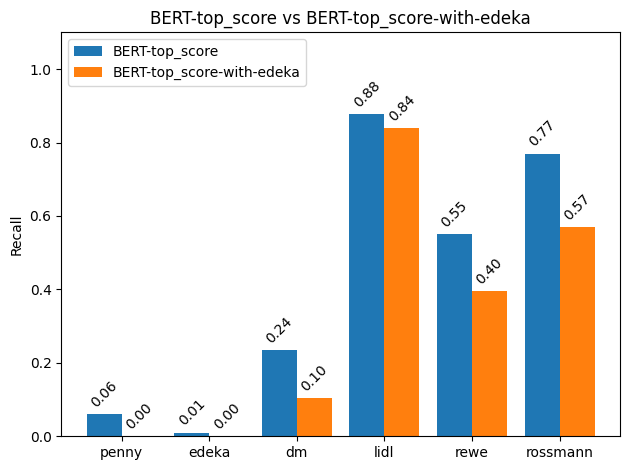

In [14]:
model_comparison_barplot(
    [benchmark_data['bert-no-curr-top_score']['recall'],
    benchmark_data['bert-top_score-with-edeka']['recall']],
    ['BERT-top_score',
    'BERT-top_score-with-edeka'],
    'Recall',
    'bert_vs_bert_with_edeka_recall'
)

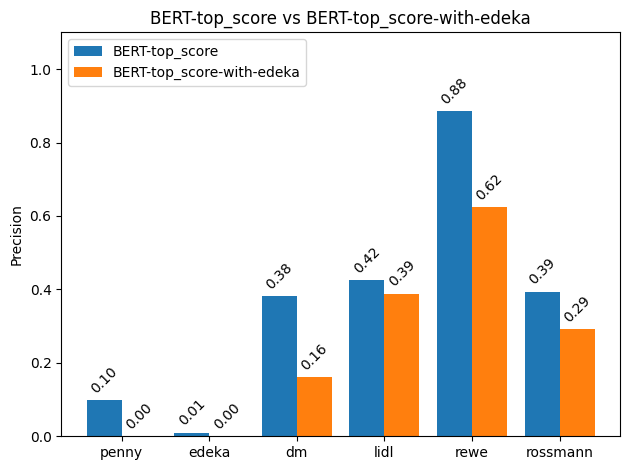

In [15]:
model_comparison_barplot(
    [benchmark_data['bert-no-curr-top_score']['precision'],
    benchmark_data['bert-top_score-with-edeka']['precision']],
    ['BERT-top_score',
    'BERT-top_score-with-edeka'],
    'Precision',
    'bert_vs_bert_with_edeka_precision'
)

# Quantizations

In [16]:
quantized_model_names = ['llama-wth-not_quantized', 'llama-wth-q8_0', 'llama-wth-q4_k_m', 'llama-wth-q4_0']
quantizations = ['not_quantized', 'q8_0', 'q4_k_m', 'q4_0']
quantization_labels = ['Not Quantized', 'Q8_0', 'Q4_K_M', 'Q4_0']

In [17]:
def quant_comparision_plot(metric, title, ylabel, filename):
    penny_results = [benchmark_data[m][metric]['penny'] for m in quantized_model_names]
    edeka_results = [benchmark_data[m][metric]['edeka'] for m in quantized_model_names]
    dm_results = [benchmark_data[m][metric]['dm'] for m in quantized_model_names]
    lidl_results = [benchmark_data[m][metric]['lidl'] for m in quantized_model_names]
    rewe_results = [benchmark_data[m][metric]['rewe'] for m in quantized_model_names]
    rossmann_results = [benchmark_data[m][metric]['rossmann'] for m in quantized_model_names]

    plt.plot(quantization_labels, penny_results, marker='o', label='penny')
    plt.plot(quantization_labels, edeka_results, marker='s', label='edeka')
    plt.plot(quantization_labels, dm_results, marker='^', label='dm')
    plt.plot(quantization_labels, lidl_results, marker='d', label='lidl')
    plt.plot(quantization_labels, rewe_results, marker='<', label='rewe')
    plt.plot(quantization_labels, rossmann_results, marker='>', label='rossmann')

    plt.title(title)
    plt.xlabel('Quantization')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

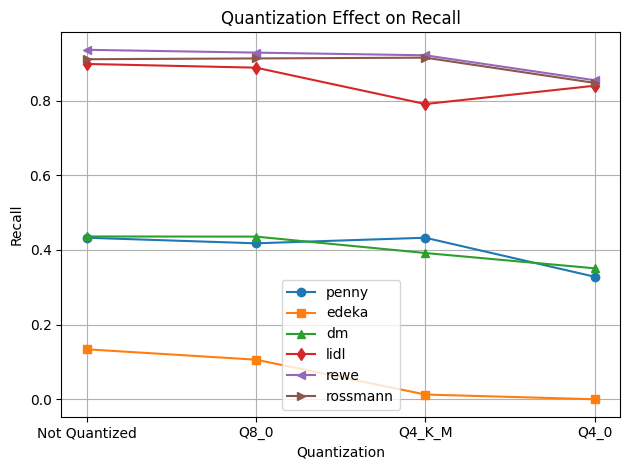

In [18]:
quant_comparision_plot(
    'recall', 
    'Quantization Effect on Recall', 
    'Recall', 
    'quantization_effect_on_recall'
)

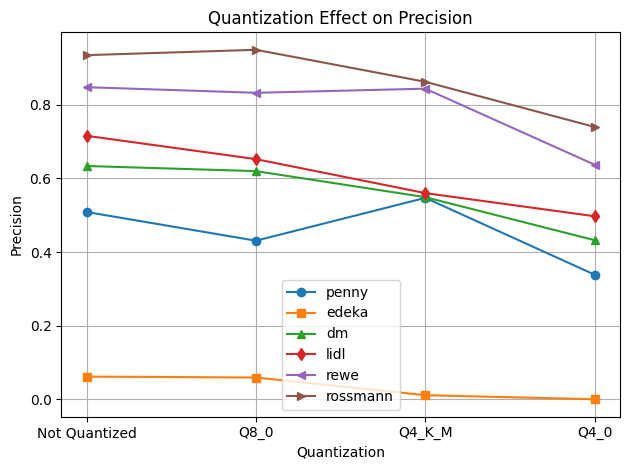

In [19]:
quant_comparision_plot(
    'precision', 
    'Quantization Effect on Precision', 
    'Precision', 
    'quantization_effect_on_precision'
)

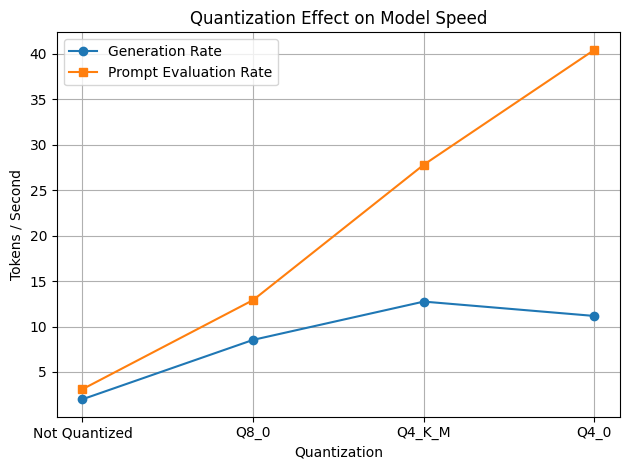

In [20]:
generation_rates = [quant_data[m]['generation_rate'] for m in quantizations]
prompt_eval_rates = [quant_data[m]['prompt_eval_rate'] for m in quantizations]

plt.plot(quantization_labels, generation_rates, marker='o', label='Generation Rate')
plt.plot(quantization_labels, prompt_eval_rates, marker='s', label='Prompt Evaluation Rate')

plt.title('Quantization Effect on Model Speed')
plt.xlabel('Quantization')
plt.ylabel('Tokens / Second')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_model_speed', dpi=300, bbox_inches='tight')
plt.show()

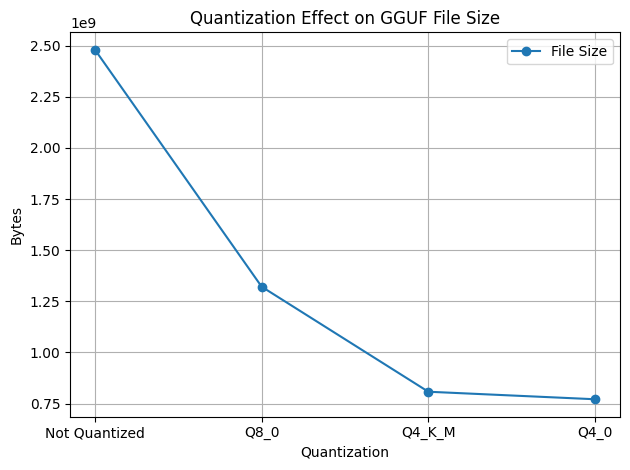

In [21]:
file_sizes = [quant_data[m]['file_size'] for m in quantizations]

plt.plot(quantization_labels, file_sizes, marker='o', label='File Size')

plt.title('Quantization Effect on GGUF File Size')
plt.xlabel('Quantization')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_gguf_file_size', dpi=300, bbox_inches='tight')
plt.show()

# Appwise

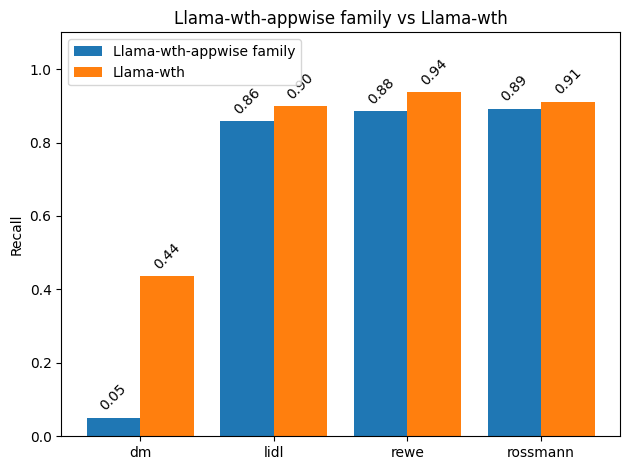

In [22]:
model_comparison_barplot(
    [benchmark_data['llama-appwise-family']['recall'],
    benchmark_data['llama-wth-not_quantized']['recall']],
    ['Llama-wth-appwise family',
    'Llama-wth'],
    'Recall',
    'llama_wth_appwise_recall'
)

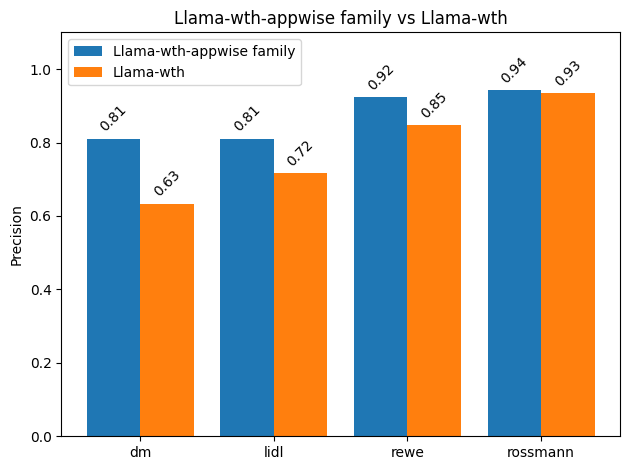

In [23]:
model_comparison_barplot(
    [benchmark_data['llama-appwise-family']['precision'],
    benchmark_data['llama-wth-not_quantized']['precision']],
    ['Llama-wth-appwise family',
    'Llama-wth'],
    'Precision',
    'llama_wth_appwise_precision'
)

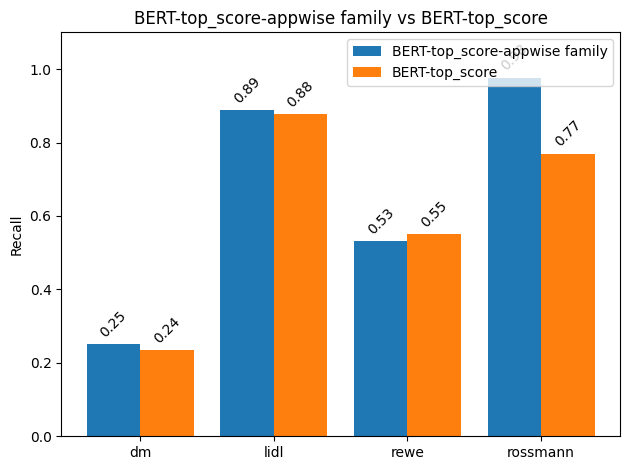

In [24]:
model_comparison_barplot(
    [benchmark_data['bert-appwise-family']['recall'],
    benchmark_data['bert-no-curr-top_score']['recall']],
    ['BERT-top_score-appwise family',
    'BERT-top_score'],
    'Recall',
    'bert_top_score_appwise_recall'
)

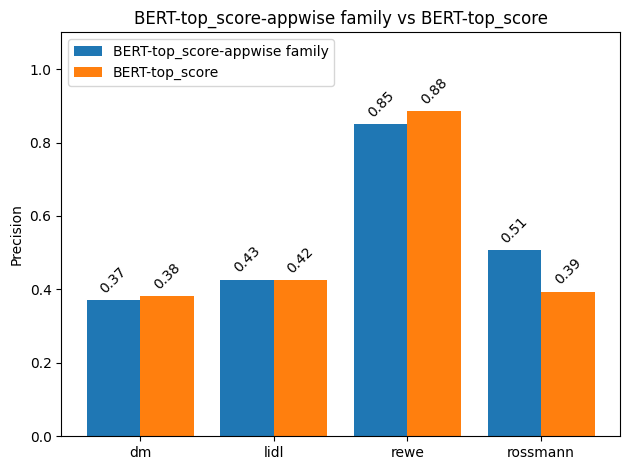

In [25]:
model_comparison_barplot(
    [benchmark_data['bert-appwise-family']['precision'],
    benchmark_data['bert-no-curr-top_score']['precision']],
    ['BERT-top_score-appwise family',
    'BERT-top_score'],
    'Precision',
    'bert_top_score_appwise_precision'
)